# Quick tests outside of Test macro

In [1]:
using GalacticDynamics
using Test
using PythonCall
using DifferentialEquations
using CairoMakie
using BenchmarkTools


pyimport("sys")."path".append("")
pyimport("sys")."path".append("python")
accelerations_py = pyimport("accelerations")
au = pyimport("astropy.units")
gd = pyimport("gala.dynamics")
gp = pyimport("gala.potential")
gu = pyimport("gala.units")
gi = pyimport("gala.integrate")

Python: <module 'gala.integrate' from '/home/mmestre/.conda/envs/cosmos/lib/python3.11/site-packages/gala/integrate/__init__.py'>

In [2]:

t₁, t₂ = 0.0, 3.0
t_range = (t₁, t₂)
Δt = 0.01
n_max = (t₂-t₁)/Δt
x₀ = -50*[1,0,0]
v₀ = 200*[0,1,0]
m = 10.0^12*𝕦.m  # Msun
a = 20.0*𝕦.l
pot = NFW(m, a)
c = concentration(pot)
f(x) = log(1+x)-x/(1+x)
const 𝔹 = f(c)
m_g = m/f(c)
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
pot_Gala = gp.NFWPotential(Py(adimensional(m_g))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
w₀ = gd.PhaseSpacePosition(pos=Py(x₀)*au.kpc, vel=Py(v₀)*au.kpc/au.Gyr)

Python: <PhaseSpacePosition cartesian, dim=3, shape=()>

In [3]:
acc =  acceleration(pot,x₀)[1]
acc_Gala = pyconvert(Vector{Float64},pot_Gala.acceleration(w₀)[0])[1];
acc_diff = abs(acc - acc_Gala)

2.2737367544323206e-13

𝕤.ode = Vern8(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true,)
sol_gala.t[-1] = <py Quantity 3. Gyr>
sol.t[end] = 3.0
sol_gala.x[0 + 100] = <py Quantity 59.75059963 kpc>
(sol.x[1, :])[1 + 100] = 59.75059963394431
findmax(sol_diff) = (1.6981971384666394e-11, 55)


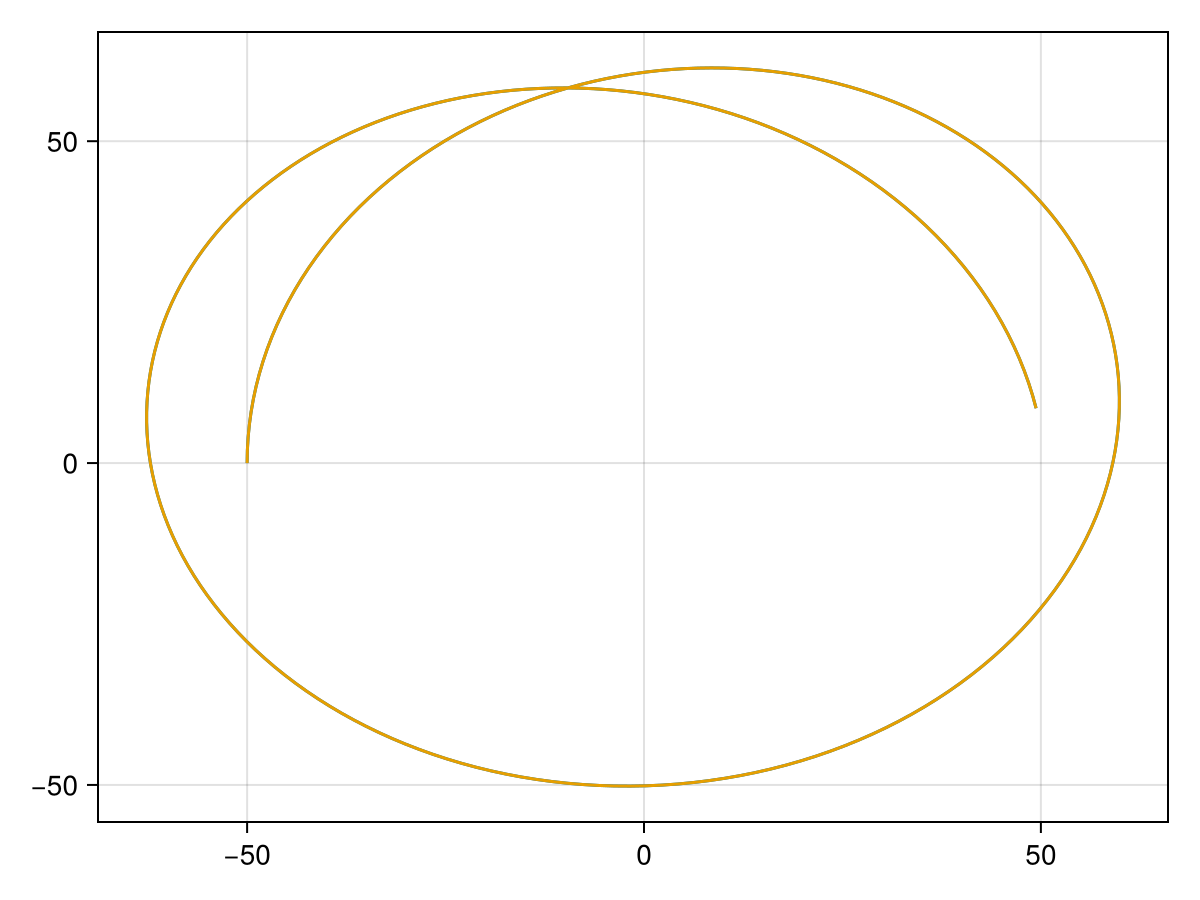

In [11]:
sol_gala = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,
                                    Integrator_kwargs=Dict("rtol"=>5.0e-12, "atol"=>0.5e-12))
sol = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(; reltol=5.0e-12, abstol=0.5e-12,saveat=Δt))
@show 𝕤.ode
@show sol_gala.t[-1]
@show sol.t[end]
@show sol_gala.x[0+100]
@show sol.x[1,:][1+100]
orb_gala_x = pyconvert(Vector{Float64}, sol_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, sol_gala.y)
orb_x = sol.x[1,:]
orb_y = sol.x[2,:]
sol_diff = abs.(orb_gala_x-orb_x)
@show findmax(sol_diff)
lines(orb_gala_x,orb_gala_y)
lines!(orb_x,orb_y)
current_figure()



In [19]:
@benchmark pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,

                                    Integrator=gi.DOPRI853Integrator,
                                    Integrator_kwargs=Dict("rtol"=>5.0e-10))


BenchmarkTools.Trial: 2860 samples with 1 evaluation.
 Range (min … max):  1.427 ms …  39.565 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.638 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.735 ms ± 768.842 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄█▇▄▂                                                       
  ▃█████▇▇▆▆▇██▇▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.43 ms         Histogram: frequency by time        2.98 ms <

 Memory estimate: 2.27 KiB, allocs estimate: 89.

In [21]:
@benchmark evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(; reltol=5.0e-10, saveat=Δt))

BenchmarkTools.Trial: 493 samples with 1 evaluation.
 Range (min … max):   8.062 ms … 518.500 ms  ┊ GC (min … max):  0.00% … 98.17%
 Time  (median):      8.617 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   10.137 ms ±  22.969 ms  ┊ GC (mean ± σ):  12.89% ±  8.71%

    ▁ █▆▅▅▁                                                     
  ▃▅███████▆▅▅▃▄▄▁▂▁▂▁▃▃▄▄▅▄▄▄▃▂▃▃▁▂▁▁▁▂▂▂▁▁▂▂▂▂▂▂▃▂▃▃▃▃▁▂▃▂▂▂ ▃
  8.06 ms         Histogram: frequency by time         12.6 ms <

 Memory estimate: 6.45 MiB, allocs estimate: 73478.